In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [3]:
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())

In [4]:
dls = fields.dataloaders('../input/brain-tumor-classification-mri')

In [5]:
dls.vocab

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

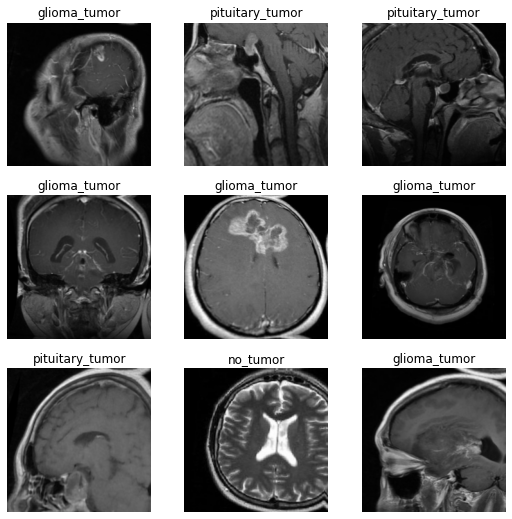

In [6]:
dls.show_batch()

In [7]:
learn = vision_learner(dls,resnet152,metrics = [accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [8]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.217734,1.362635,0.696319,0.303681,00:54


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.621897,0.460793,0.891104,0.108896,01:06


SuggestedLRs(valley=4.365158383734524e-05)

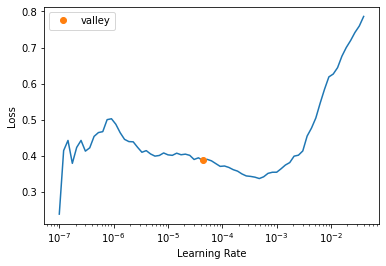

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(4,6e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.358168,0.392136,0.886503,0.113497,01:11
1,0.304434,0.297946,0.921779,0.078221,01:15
2,0.207681,0.210270,0.938650,0.061350,01:16
3,0.156900,0.216908,0.944785,0.055215,01:15


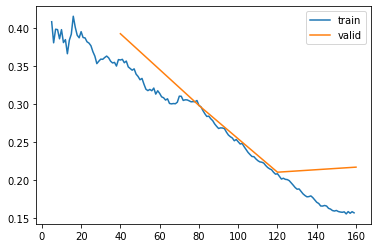

In [11]:
learn.recorder.plot_loss()

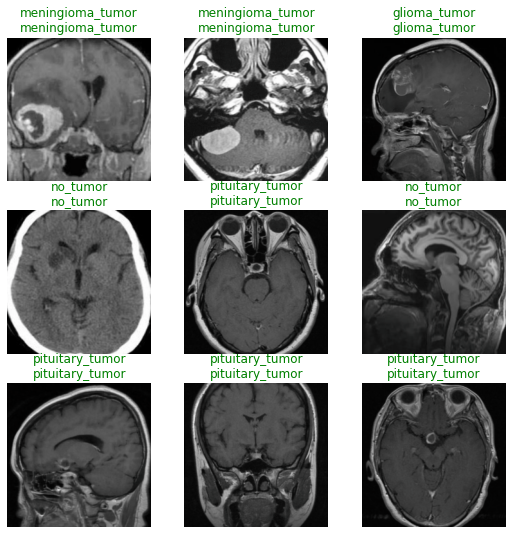

In [12]:
learn.show_results()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(4,lr_max=slice(1e-5,6e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.099473,0.221364,0.943252,0.056748,01:15
1,0.090346,0.212335,0.934049,0.065951,01:15
2,0.089397,0.171062,0.949386,0.050613,01:14
3,0.071374,0.167212,0.949386,0.050613,01:10


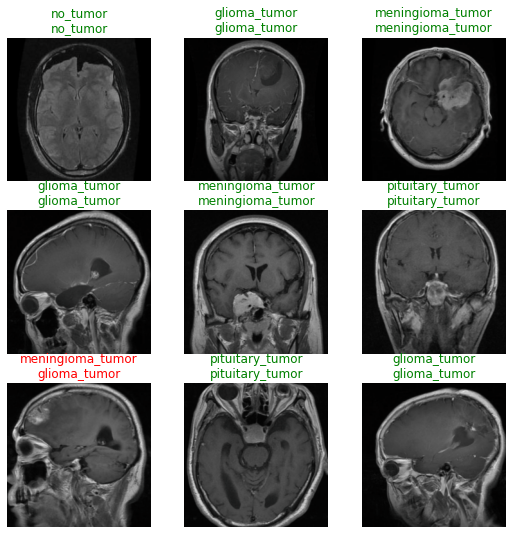

In [14]:
learn.show_results()

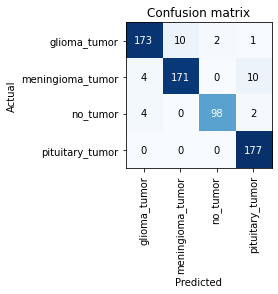

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

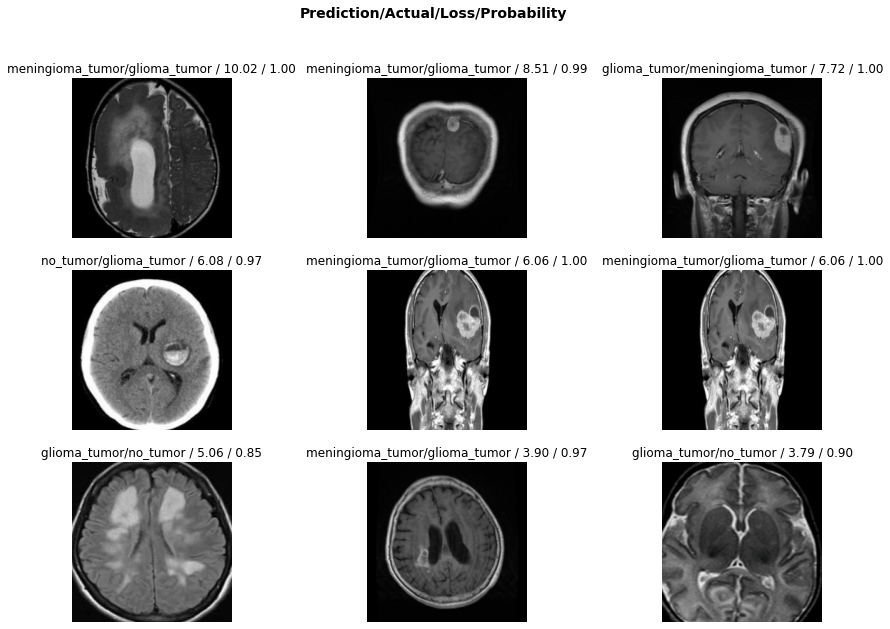

In [16]:
interp.plot_top_losses(9, figsize=(15,10))

In [17]:
learn.export()

In [18]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

In [19]:
learn.predict(path/'../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg')

('glioma_tumor',
 TensorBase(0),
 TensorBase([1.0000e+00, 2.1340e-08, 1.2033e-06, 2.6330e-08]))

In [20]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [21]:
VBox([widgets.Label('Select your MRI'),btn_upload, btn_run, out_pl, lbl_pred])